In [1]:
!pip install transformers --quiet
!pip install seaborn --quiet
!pip install sklearn --quiet

import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issu

In [2]:
# Cargar el modelo preentrenado de BERT
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Congelar las capas del modelo BERT
bert_model.bert.trainable = False

# Definir los parámetros de entrada
max_length = 140

# Crear las capas de entrada
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

# Obtener la salida del modelo BERT
outputs = bert_model(input_ids, attention_mask=attention_mask)
pooled_output = outputs.pooler_output

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [3]:
# Definir la arquitectura de la última parte de la red
x = tf.keras.layers.Dropout(0.2)(pooled_output)
output_3_classes = tf.keras.layers.Dense(3, activation='softmax')(x)

# Definir el modelo final
model_3_classes = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output_3_classes)

# Compilar el modelo
model_3_classes.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Mostrar el resumen del modelo
model_3_classes.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                      

Cantidad de críticas: 15746


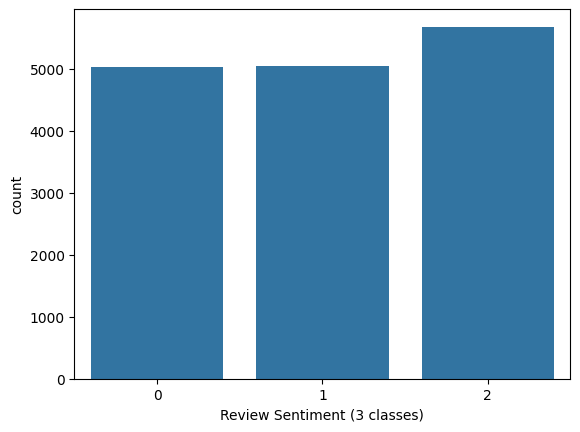

In [4]:
# # Descargar los datos
# !curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

# Cargar los datos en un DataFrame
df = pd.read_csv('reviews.csv')

# Mostrar el número total de críticas
print("Cantidad de críticas:", len(df))

# Crear una nueva columna 'sentiment' basada en el puntaje para 3 clases
df['sentiment_3_classes'] = df.score.apply(lambda x: 0 if x <= 2 else 1 if x == 3 else 2)
class_names_3 = ['negative', 'neutral', 'positive']

# Mostrar la distribución de clases
sns.countplot(x=df.sentiment_3_classes)
plt.xlabel('Review Sentiment (3 classes)')
plt.show()

# 5

In [6]:
# Preparar las sentencias y etiquetas
sentences = df['content'].values
y_3_classes = tf.keras.utils.to_categorical(df['sentiment_3_classes'].values, num_classes=3)

# Dividir los datos en entrenamiento, validación y prueba
X_train_val, X_test, y_train_val, y_test_3_classes = train_test_split(sentences, y_3_classes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Tokenizar los datos
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(sentences):
    return bert_tokenizer(sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()

X_train_tokens = tokenize(X_train)
X_val_tokens = tokenize(X_val)
X_test_tokens = tokenize(X_test)

6

In [7]:
# Entrenar el modelo
history_3_classes = model_3_classes.fit([X_train_tokens['input_ids'], X_train_tokens['attention_mask']],
                                        y_train, epochs=5, validation_data=([X_val_tokens['input_ids'],
                                                                            X_val_tokens['attention_mask']], y_val))

# Evaluar el modelo en el conjunto de prueba
y_pred_3_classes = model_3_classes.predict([X_test_tokens['input_ids'], X_test_tokens['attention_mask']])
y_pred_3_classes = np.argmax(y_pred_3_classes, axis=1)
y_test_3_classes = np.argmax(y_test_3_classes, axis=1)

print(classification_report(y_test_3_classes, y_pred_3_classes, target_names=class_names_3))

Epoch 1/5


315/315 [==============================] - 1905s 6s/step - loss: 1.1067 - accuracy: 0.4012 - val_loss: 0.9959 - val_accuracy: 0.5028
Epoch 2/5
315/315 [==============================] - 2016s 6s/step - loss: 1.0279 - accuracy: 0.4723 - val_loss: 0.9670 - val_accuracy: 0.5385
Epoch 3/5
315/315 [==============================] - 1677s 5s/step - loss: 0.9932 - accuracy: 0.5047 - val_loss: 0.9698 - val_accuracy: 0.4952
Epoch 4/5
315/315 [==============================] - 2227s 7s/step - loss: 0.9761 - accuracy: 0.5154 - val_loss: 0.9258 - val_accuracy: 0.5421
Epoch 5/5
99/99 [==============================] - 492s 5s/step
              precision    recall  f1-score   support

    negative       0.49      0.81      0.61       997
     neutral       0.45      0.26      0.33       979
    positive       0.76      0.61      0.67      1174

    accuracy                           0.56      3150
   macro avg       0.56      0.56      0.54      3150
weighted avg       0.58      0.56   

7

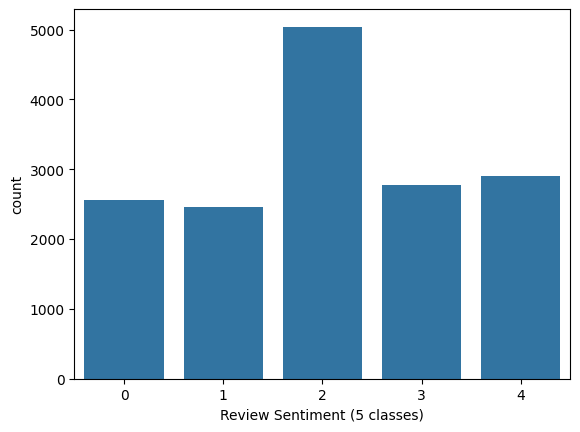

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

In [9]:
# Crear una nueva columna 'sentiment' basada en el puntaje para 5 clases
df['sentiment_5_classes'] = df.score.apply(lambda x: x - 1)
class_names_5 = ['1', '2', '3', '4', '5']

# Mostrar la distribución de clases
sns.countplot(x=df.sentiment_5_classes)
plt.xlabel('Review Sentiment (5 classes)')
plt.show()

# Preparar las etiquetas para 5 clases
y_5_classes = tf.keras.utils.to_categorical(df['sentiment_5_classes'].values, num_classes=5)

# Dividir los datos en entrenamiento, validación y prueba
X_train_val, X_test, y_train_val, y_test_5_classes = train_test_split(sentences, y_5_classes, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train = [str(x) for x in X_train]
X_val = [str(x) for x in X_val]
X_test = [str(x) for x in X_test]

# Tokenizar los datos
X_train_tokens = tokenize(X_train)
X_val_tokens = tokenize(X_val)
X_test_tokens = tokenize(X_test)

# Definir la arquitectura de la última parte de la red para 5 clases
output_5_classes = tf.keras.layers.Dense(5, activation='softmax')(x)

# Definir el modelo final
model_5_classes = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output_5_classes)

# Compilar el modelo
model_5_classes.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Mostrar el resumen del modelo
model_5_classes.summary()

8

In [10]:
# Entrenar el modelo
history_5_classes = model_5_classes.fit([X_train_tokens['input_ids'], X_train_tokens['attention_mask']],
                                        y_train, epochs=5, validation_data=([X_val_tokens['input_ids'],
                                                                            X_val_tokens['attention_mask']], y_val))

# Evaluar el modelo en el conjunto de prueba
y_pred_5_classes = model_5_classes.predict([X_test_tokens['input_ids'], X_test_tokens['attention_mask']])
y_pred_5_classes = np.argmax(y_pred_5_classes, axis=1)
y_test_5_classes = np.argmax(y_test_5_classes, axis=1)

print(classification_report(y_test_5_classes, y_pred_5_classes, target_names=class_names_5))

Epoch 1/5
315/315 [==============================] - 2542s 8s/step - loss: 1.6136 - accuracy: 0.2921 - val_loss: 1.4856 - val_accuracy: 0.3631
Epoch 2/5
315/315 [==============================] - 2091s 7s/step - loss: 1.5173 - accuracy: 0.3409 - val_loss: 1.4743 - val_accuracy: 0.3726
Epoch 3/5
315/315 [==============================] - 2012s 6s/step - loss: 1.4842 - accuracy: 0.3548 - val_loss: 1.4305 - val_accuracy: 0.3909
Epoch 4/5
315/315 [==============================] - 1976s 6s/step - loss: 1.4467 - accuracy: 0.3729 - val_loss: 1.4199 - val_accuracy: 0.3476
Epoch 5/5
99/99 [==============================] - 456s 5s/step
              precision    recall  f1-score   support

           1       0.50      0.31      0.38       515
           2       0.50      0.00      0.01       482
           3       0.39      0.74      0.51       979
           4       0.30      0.11      0.16       591
           5       0.51      0.66      0.57       583

    accuracy                          

--

In [17]:
def analyze_sentence(text, model_3_classes, model_5_classes, class_names_3, class_names_5):
    # Tokenizar la frase
    tokens = tokenize([text])
    
    # Predecir la clase para la frase con el modelo de 3 clases
    prediction_3_classes = model_3_classes.predict([tokens['input_ids'], tokens['attention_mask']])
    predicted_class_3 = np.argmax(prediction_3_classes, axis=1)[0]
    
    # Predecir la clase para la frase con el modelo de 5 clases
    prediction_5_classes = model_5_classes.predict([tokens['input_ids'], tokens['attention_mask']])
    predicted_class_5 = np.argmax(prediction_5_classes, axis=1)[0]
    
    # Obtener las etiquetas de las clases predichas
    pred_class_3 = class_names_3[predicted_class_3]
    pred_class_5 = class_names_5[predicted_class_5]
    
    print(f"Frase: {text}")
    print(f"Predicción (3 clases): {pred_class_3}")
    print(f"Predicción (5 clases): {pred_class_5}")
    print()
    
    return pred_class_3, pred_class_5

In [18]:
# Lista de frases para analizar
texts = [
    "This app is amazing, I use it every day!",
    "Terrible experience, the app crashes all the time.",
    "It's a decent app, but it has some bugs.",
    "The app is okay, but there are better alternatives.",
    "I hate the new update, it ruined everything.",
    "This app works perfectly."
]

# Analizar cada frase
for text in texts:
    analyze_sentence(text, model_3_classes, model_5_classes, class_names_3, class_names_5)

1/1 [==============================] - 0s 80ms/step
Frase: This app is amazing, I use it every day!
Predicción (3 clases): positive
Predicción (5 clases): 5

1/1 [==============================] - 0s 88ms/step
Frase: Terrible experience, the app crashes all the time.
Predicción (3 clases): negative
Predicción (5 clases): 1

1/1 [==============================] - 0s 81ms/step
Frase: It's a decent app, but it has some bugs.
Predicción (3 clases): negative
Predicción (5 clases): 3

1/1 [==============================] - 0s 68ms/step
Frase: The app is okay, but there are better alternatives.
Predicción (3 clases): negative
Predicción (5 clases): 3

1/1 [==============================] - 0s 79ms/step
Frase: I hate the new update, it ruined everything.
Predicción (3 clases): negative
Predicción (5 clases): 5

1/1 [==============================] - 0s 86ms/step
Frase: This app works perfectly.
Predicción (3 clases): positive
Predicción (5 clases): 5



In [11]:
# Frase de ejemplo
text = "I love this app!"

# Tokenizar la frase
tokens = tokenize([text])

# Predecir la clase para la frase con el modelo de 3 clases
prediction_3_classes = model_3_classes.predict([tokens['input_ids'], tokens['attention_mask']])
predicted_class_3 = np.argmax(prediction_3_classes, axis=1)[0]

# Predecir la clase para la frase con el modelo de 5 clases
prediction_5_classes = model_5_classes.predict([tokens['input_ids'], tokens['attention_mask']])
predicted_class_5 = np.argmax(prediction_5_classes, axis=1)[0]

# Mapear las predicciones a las etiquetas de las clases
print(f"Frase: {text}")
print(f"Predicción (3 clases): {class_names_3[predicted_class_3]}")
print(f"Predicción (5 clases): {class_names_5[predicted_class_5]}")


1/1 [==============================] - 3s 3s/step
Frase: I love this app!
Predicción (3 clases): positive
Predicción (5 clases): 5
